In [50]:
import numpy as np
import pandas as pd
import torch
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import data
import viz
import argparse
import pickle

In [22]:
def plot_params(fname):
    df = pd.read_csv('debug/{}.txt'.format(fname), sep='\t')
    if len(df) == 1:
        df = pd.concat([df, df])
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for param, data in df.iteritems():
        if param[:3] == 'len':
            ax2.plot(data.values, label=param, c=['black', 'black', 'gray'][int(param[-1])])
        else:
            ax1.plot(data.values, label=param)
    ax1.legend(loc='center left')
    ax2.legend(loc='center right')
    ax2.set_ylim([0, 16])
    ax1.set_xlabel('epochs')
    plt.title(fname)
    plt.show()

In [9]:
parser = argparse.ArgumentParser()
data.add_args(parser)
args = parser.parse_args(['--dataset', 'unit_test'])
train, test = data.dataset_from_args(args)

# Section 1a
Investigating why unsupervised model fails on simple unit tests

## Unit test dataset
- Same sequence every time
- One-hot, one-dimensional features

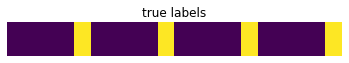

[0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1]


In [14]:
labels = test[0]['labels'].detach().cpu().numpy()
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(np.tile(labels, (2, 1)))
ax1.axis('off')
plt.title('true labels')
plt.show()
print(labels)

In [16]:
features = test[0]['features'].detach().cpu().numpy()
print('features:')
print(features.flatten())

features:
[0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]


## Testing various models

### supervised parameters
- **mean1** and **mean2** are the gaussian means of each state, which should be 0 and 1
- **1>1** and **2>2** are self-transition probabilities, which should be 0
- **1>2** and **2>1** are transition probabilities, which shoudl be 1 in this case
- **len1** and **len2** are the lengths of each state, which should be 4 and 1 respectively

### fixed hyperparameters
- learning rate: *1e-1*
- gaussian covariance: *eye* [[1 0][0 1]]

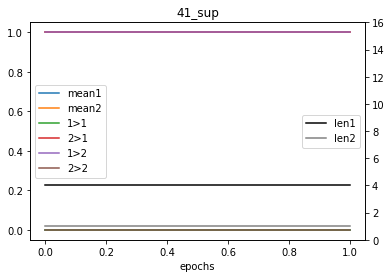

In [35]:
#supervised
plot_params('41_sup')

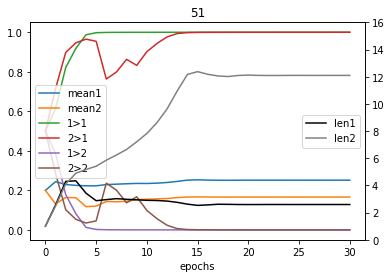

In [24]:
#fully unsupervised
#converges to a local minimum (?) where it's stuck in state 1
plot_params('41')

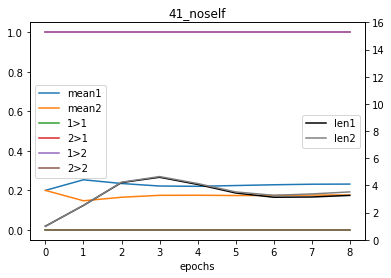

In [42]:
#no self-transitions
#converged to local minimum (?) with unconverged means and short lengths
plot_params('41_noself')

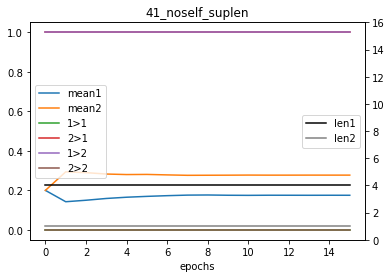

In [41]:
#no self-transitions, supervised lengths
#means don't diverge
plot_params('41_noself_suplen')

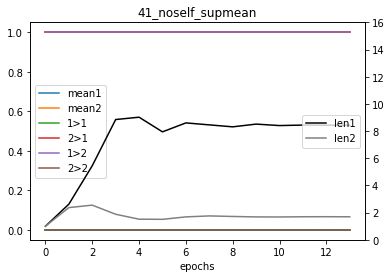

In [39]:
#no self-transitions, supervised means
#lengths converge to wrong values
plot_params('41_noself_supmean')

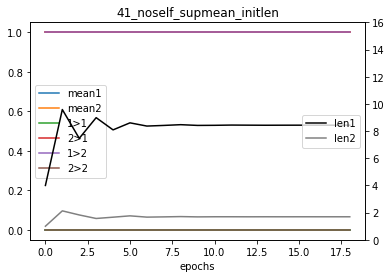

In [40]:
#no self-transitions, supervised means, correctly initialized lengths
#converges to incorrect lengths, despite correct initialization
plot_params('41_noself_supmean_initlen')

## Takeaways
All unsupervised models fail. Even when transition and emission probabilities are fixed, the model converges to the wrong lengths. This happens even when lengths are initialized to the correct values. This suggests that the viterbi predictions are incorrect, even with the parameters correct. The only difference between the unsupervised and supervised model at that point is **covariance**. Let's verify that this is where the problem lies.

# Section 1b
Same unit tests with supervised **covariance**.

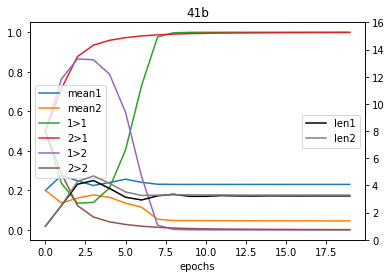

In [38]:
#unsupervised
#transitions are going the right direction at first, but switch to converge to stuck in self-transition
plot_params('41b')

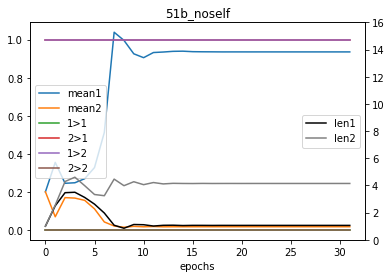

In [32]:
#no self-transitions
#succeeds
plot_params('41b_noself')

## Takeaways
- Covariance was indeed the major factor causing the model to fail to converge on the right values. Covariance can't be trained, but trying various initializations, or meta-learning, may be necessary to get a working unsupervised model.
- Even with correct covariance, the fully unsupervised model is susceptible to getting stuck in self-transitioning local minima. We'll investigate this further in the next section.

# Section 2
Investigating when the model falls into local minima, despite correct covariance

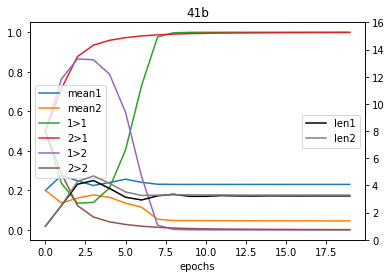

In [43]:
#unsupervised (base case)
#stuck in self-transition
plot_params('41b')

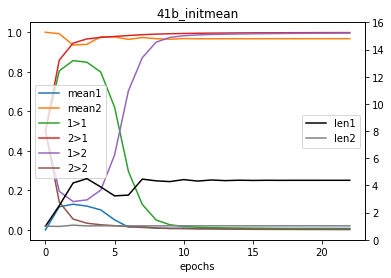

In [44]:
#correctly initialized means
#succeeds
#headed toward self-transition trough initially, but corrects toward global minimum
plot_params('41b_initmean')

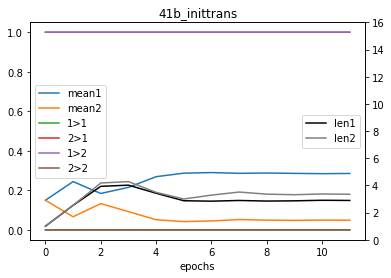

In [49]:
#correctly initialized transitions
#transitions remain correct, but converges to incorrect lengths/means
plot_params('41b_inittrans')

**Visualizing this common local minimum**

C:\Users\dylan\.conda\envs\act-recog\lib\site-packages\torch_struct\semimarkov.py:175: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  on = edge.nonzero()


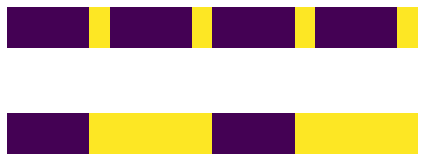

In [51]:
with open('models/unit_test_unsupervised_41b_inittrans.p', 'rb') as f:
    meta = pickle.load(f)
args = meta['args']
model = torch.load(meta['model'])
viz.viz_state_seq(model, test, remap=True)

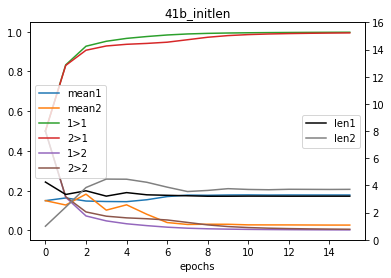

In [55]:
#correctly initialized lengths
#converges to local minimum
#lengths rapidly stray from their initialization
plot_params('41b_initlen')

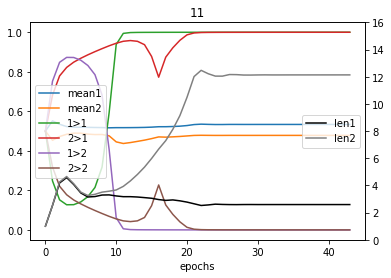

In [57]:
#unsupervised with reduced idle duration, so sequence is 01010101010101010101
#going in the right direction at first, but then plummets to self-transition minimum
plot_params('11')

**Visualizing this local minimum**

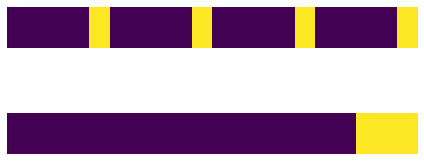

In [58]:
with open('models/unit_test_unsupervised_11.p', 'rb') as f:
    meta = pickle.load(f)
args = meta['args']
_, dset = data.dataset_from_args(args)
model = torch.load(meta['model'])
viz.viz_state_seq(model, dset, remap=True)

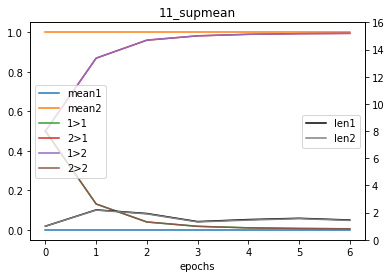

In [61]:
#supervised mean
#succeeds, though length really wants to increase
plot_params('11_supmean')

## Takeaways
The model is highly susceptible to local minima. This might be helped by tweaking initializations, but it doesn't seem like there's a single solution that's good for all datasets.

# Section 3
More nbc-like